# CS-E4740 Federated Learning Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
SEED = 42

## 1 Dataset
https://microsoft.github.io/r-server-hospital-length-of-stay/input_data.html

### 1.1 Feature Engineering

Here, we just eliminate irrelevant or ambigious features. Also, convert some features to one-hot-encodings. 

Important: No preprocessing here. We prefer to preprocess data in local datasets.

In [2]:
df = pd.read_csv("./LengthOfStay.csv")
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


In [3]:
df.loc[df.rcount == "5+", "rcount"] = 5
df.rcount = df.rcount.astype(int)
df = pd.concat((df, pd.get_dummies(df.rcount, prefix="rcount")), axis=1)
# Drop irrelevant and ambigious colums
df = df.drop(["eid", "rcount", "vdate", "discharged",  "secondarydiagnosisnonicd9"], axis=1)
df.head()

,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,...,pulse,respiration,facid,lengthofstay,rcount_0,rcount_1,rcount_2,rcount_3,rcount_4,rcount_5
0,F,0,0,0,0,0,0,0,0,0,...,96,6.5,B,3,True,False,False,False,False,False
1,F,0,0,0,0,0,0,0,0,0,...,61,6.5,A,7,False,False,False,False,False,True
2,F,0,0,0,0,0,0,0,0,0,...,64,6.5,B,3,False,True,False,False,False,False
3,F,0,0,0,0,0,0,0,0,0,...,76,6.5,A,1,True,False,False,False,False,False
4,F,0,0,0,1,0,1,0,0,0,...,67,5.6,E,4,True,False,False,False,False,False


In [4]:
df = df.assign(gender=(df.gender == "F").astype(int))
binary_cols = ['dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition']

# Generate another feature that indicates how many conditions the patient has
df = df.assign(n_conditions=df[binary_cols].sum(1))
df = df.drop(binary_cols, axis=1)

In [5]:
facilities = len(df.facid.unique())
df.head(10)

,gender,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,facid,lengthofstay,rcount_0,rcount_1,rcount_2,rcount_3,rcount_4,rcount_5,n_conditions
0,1,0,11.50,14.20,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,B,3,True,False,False,False,False,False,0
1,1,0,9.00,4.10,136.731692,94.078507,8.0,0.943164,28.460516,61,6.5,A,7,False,False,False,False,False,True,0
2,1,0,8.40,8.90,133.058514,130.530524,12.0,1.065750,28.843812,64,6.5,B,3,False,True,False,False,False,False,0
3,1,0,11.90,9.40,138.994023,163.377028,12.0,0.906862,27.959007,76,6.5,A,1,True,False,False,False,False,False,0
4,1,0,9.10,9.05,138.634836,94.886654,11.5,1.242854,30.258927,67,5.6,E,4,True,False,False,False,False,False,2
5,0,0,14.80,17.80,136.593064,120.265259,11.0,0.884663,27.875940,83,6.1,B,6,False,False,False,True,False,False,0
6,1,0,9.40,8.50,137.151328,124.335692,6.0,0.923083,29.928817,68,6.5,A,6,False,False,False,False,True,False,0
7,1,0,11.25,7.15,136.069688,152.265862,11.0,0.768106,32.999171,63,6.0,E,3,True,False,False,False,False,False,1
8,1,0,11.90,9.40,135.980274,100.283199,12.0,1.178786,28.802682,69,6.5,E,3,True,False,False,False,False,False,1
9,1,0,10.70,8.50,136.893431,167.066115,10.0,1.585072,32.503727,65,6.5,E,2,True,False,False,False,False,False,0


## 2 Emprical Graph and Preprocessing

In [6]:
label_col = "lengthofstay"
facility_id_col = "facid"
feature_cols = df.columns.to_list()
feature_cols.remove(label_col)
feature_cols.remove(facility_id_col)
numerical_feature_cols = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'n_conditions']
len(feature_cols)

18

In [7]:
def get_emprical_graph(data : pd.DataFrame, print_sizes : bool = False):
    """
    Adds nodes to empirical graph. 
    Applies standard scaling to features of each local dataset.

    Inputs:
    data (pd.DataFrame): Dataset where data of each hospital mixed
    print_sizes (bool): If true -> function prints the dataset sizes for each node

    Returns:
    G (nx.Graph): Empirical graph without edges
    """
    num_facilities = len(data.facid.unique())
    
    G = nx.Graph()
    G.add_nodes_from(range(0, num_facilities))

    for i, facility in enumerate(data.facid.unique()):
        facility_data = data[data.facid == facility]
        X = facility_data[feature_cols].values
        y = facility_data[label_col].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

        for j in range(len(feature_cols)):
            if feature_cols[j] in numerical_feature_cols:
                X_train_mean = np.mean(X_train[:, j]) 
                X_train_std = np.std(X_train[:, j])
                X_train[:, j] = (X_train[:, j] - X_train_mean) / X_train_std
                X_test[:, j] = (X_test[:, j] - X_train_mean) / X_train_std
        
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = SEED)

        
        G.nodes[i]["name"] = facility
        G.nodes[i]["X_train"] = X_train.astype("float64")
        G.nodes[i]["y_train"] = y_train
        G.nodes[i]["X_test"] = X_test.astype("float64")
        G.nodes[i]["y_test"] = y_test
        G.nodes[i]["X_val"] = X_val.astype("float64")
        G.nodes[i]["y_val"] = y_val
        G.nodes[i]["train_size"] = X_train.shape[0]
        G.nodes[i]["test_size"] = X_test.shape[0]
        G.nodes[i]["val_size"] = X_val.shape[0]
        G.nodes[i]["weights"] = np.zeros((X_train.shape[1],1))
        G.nodes[i]["z"] = None # representation vector, will be used for measuring discrepency between nodes
        if print_sizes:
            print(f"Node {i + 1} has {X.shape[0]} datapoints (training: {X_train.shape[0]},  validation: {X_val.shape[0]}, test: {X_test.shape[0]})")
    return G

def add_edges(G : nx.Graph, node_degree : int):
    """
    Adds edges to the given empirical graph using the representation vectors of each node.

    Inputs:
    G (nx.Graph): Empirical graph without edges
    node_degree (int): the minimum number of neighbors (the minimum node degree)

    Returns
    graph (nx.Graph): Empirical graph with edges
    """
    graph = G.copy()
    
    for i in graph.nodes:
        z_node = graph.nodes[i]["z"]

        d_mins = np.full(shape=node_degree, fill_value=1e10)
        edges = np.full(shape=(node_degree, 2), fill_value=[i, -1])

        for potential_neighbor in graph.nodes:
            if potential_neighbor != i:
                z_neighbor = graph.nodes[potential_neighbor]['z']
                d = np.linalg.norm(z_node - z_neighbor)

                # Find the max discrepancy so far.
                d_max_idx = np.argmax(d_mins)
                d_max = d_mins[d_max_idx]
                
                if d < d_max:
                    d_mins[d_max_idx] = d
                    edges[d_max_idx][1] = potential_neighbor

        graph.add_edges_from(edges) 

    return graph

def solve_GTVMin(G : nx.Graph, n : int = 10, d : int = 18, gtvmin_alpha : float = 0.1):
    """
    Solves GTVMin in a closed form
    If given empirical graph G does not have any edges 
        then it is equivalent to minimize MSE at each 
        local dataset individiually without sharing info.

    Inputs:
    G (nx.Graph): Empirical graph
    n (int): Number of nodes/hospitals
    d (int): Number of features
    gtvmin_alpha (float): Importance of total variation on the solution

    Returns
    w_hat (np.ndarray): Optimal weights for local models.
        shape = (n, d)
    """
    L = nx.laplacian_matrix(G).toarray()
    Q = np.zeros((n * d, n * d))
    q = np.zeros((n * d, 1))

    for i in range(n):
        X_i = G.nodes[i]["X_train"]
        y_i = G.nodes[i]["y_train"]
        m_i = X_i.shape[0]
        Q_i = X_i.T @ X_i / m_i
        start_idx, end_idx = i * d, (i + 1) * d
        Q[start_idx : end_idx, start_idx : end_idx] = Q_i
        q_i = - (2 / m_i) * X_i.T @ y_i
        q[start_idx:end_idx] = q_i[:, None]
    
    Q += gtvmin_alpha * np.kron(L, np.eye(d)) 
    w_hat = (- np.linalg.inv(Q) @ q / 2).reshape(n,d)
    return w_hat

def add_edges_rep_vector(G : nx.Graph, node_degree : int):
    """
    Creates representation vectors by learning a local linear model.
    Uses the weights of a local model as the representation vector.
    Adds edges to the given empirical graph using the representation vectors of each node.

    Inputs:
    G (nx.Graph): Empirical graph without edges
    node_degree (int): the minimum number of neighbors (the minimum node degree)

    Returns
    graph (nx.Graph): Empirical graph with edges
    """
    graph = G.copy()
    w_hat = solve_GTVMin(G, facilities)
    
    for i in graph.nodes:
        graph.nodes[i]["z"] = w_hat[i]

    graph = add_edges(graph, node_degree)

    return graph

def plot_G(G : nx.Graph):
    """
    Plots given empirical graph

    Inputs:
    G (nx.Graph): Empirical graph
    """
    
    mapping = {}
    for i in range(facilities):
        mapping[i] = i + 1
    graph = nx.relabel_nodes(G, mapping, True)

    server_client = len(graph.edges) == 0
    if server_client:
        graph.add_node("S")
        for node in range(1, facilities + 1):
            graph.add_edge("S", node)
    
    pos = nx.spring_layout(graph, seed=SEED)
    nx.draw_networkx_nodes(graph, pos, node_size=400)
    nx.draw_networkx_edges(graph, pos, node_size=400, width=2)
    nx.draw_networkx_labels(graph, pos)
    edge_labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    ax = plt.gca()
    if server_client:
        ax.text(0.85, 1, 'S: Server', bbox={'facecolor': 'white', 'pad': 10})
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(
        "fedsgd.png" if not server_client else "fedavg.png",
        transparent = True,
        dpi = 300
    )
    plt.show()
    

Node 1 has 30012 datapoints (training: 21008,  validation: 4502, test: 4502)
Node 2 has 30035 datapoints (training: 21024,  validation: 4505, test: 4506)
Node 3 has 30755 datapoints (training: 21528,  validation: 4613, test: 4614)
Node 4 has 4499 datapoints (training: 3149,  validation: 675, test: 675)
Node 5 has 4699 datapoints (training: 3289,  validation: 705, test: 705)


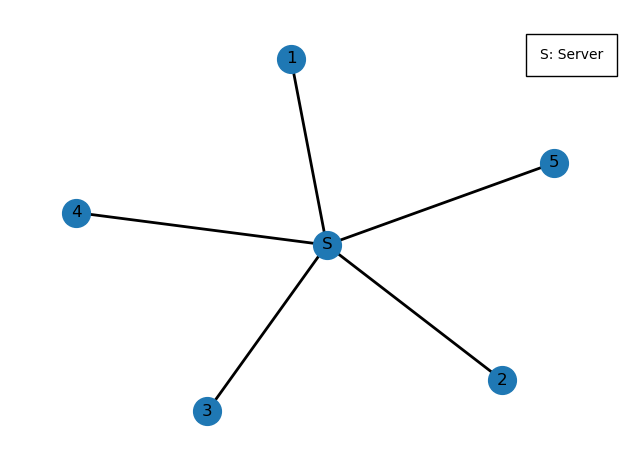

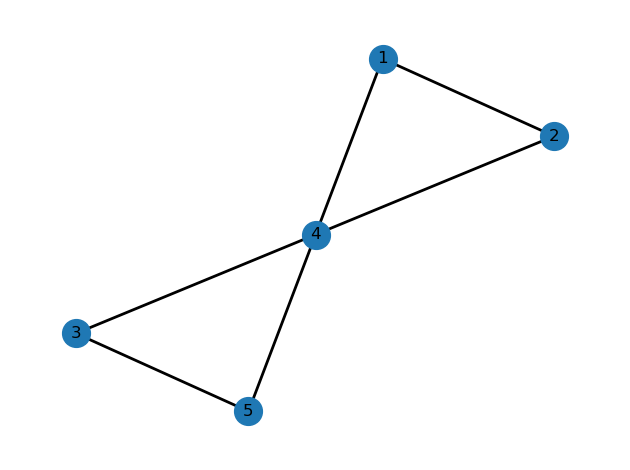

In [8]:
G = get_emprical_graph(df, True)
plot_G(G)
G = add_edges_rep_vector(G, 2)
plot_G(G)

## 3 Federated Learning Algorithms

In [9]:
def get_losses(G : nx.Graph, print_losses : bool = True):
    """
    Calculates losses of each nodes on training, validation and test sets.

    Inputs:
    G (nx.Graph): Empirical graph
    print_losses (bool): If true -> function prints the losses

    Returns:
    train_errors (np.ndarray): Losses of each node on their training sets
    val_errors (np.ndarray): Losses of each node on their validation sets
    test_errors (np.ndarray): Losses of each node on their test sets
    """
    n = len(G.nodes)
    train_errors = np.zeros(n)
    val_errors = np.zeros(n)
    test_errors = np.zeros(n)

    for node in G.nodes:
        X_train = G.nodes[node]['X_train']
        y_train = G.nodes[node]['y_train']
        X_test = G.nodes[node]['X_test']
        y_test = G.nodes[node]['y_test']
        X_val = G.nodes[node]['X_val']
        y_val = G.nodes[node]['y_val']
        w = G.nodes[node]['weights']
        
        train_errors[node] = mean_squared_error(y_train, X_train.dot(w))
        val_errors[node] = mean_squared_error(y_val, X_val.dot(w))
        test_errors[node] = mean_squared_error(y_test, X_test.dot(w))
        

    if print_losses:
        print("The average training error:", np.round(np.mean(train_errors), 3))
        print("The average validation error:", np.round(np.mean(val_errors), 3))
        print("The average test error:", np.round(np.mean(test_errors), 3))
    return train_errors, val_errors, test_errors

def print_losses(train_errors, val_errors, test_errors):
    print("Node-i: (train_errors[i], val_errors[i], test_errors[i])")
    for i in range(facilities):
        print(f"Node-{i + 1}: {(np.round(train_errors[i], 3), np.round(val_errors[i], 3), np.round(test_errors[i], 3))}")

### 3.1 FedSGD

In [10]:
def FedSGD(G : nx.Graph, gtvmin_alpha : float = 0.1, learning_rate : float = 0.001, batch_size : int = 64, max_iter : int = 100, random_seed : int = SEED):
    """
    Applies federated stochastic gradient descent to solve GTVMin

    Inputs:
    G (nx.Graph): Empirical graph
    gtvmin_alpha (float): Importance of total variation on the solution
    learning_rate (float): Learning rate
    batch_size (int): Batch size
    max_iter (int): Maximum number of iterations
    random_seed (int): Random seed for reproducibility
    """
    np.random.seed(random_seed)
    for _ in tqdm(range(max_iter)):
        for node in G.nodes:
            train_size = G.nodes[node]["train_size"]
            batch_idx = np.random.choice(train_size, batch_size, replace=False)
            X_train_batch = G.nodes[node]["X_train"][batch_idx]
            y_train_batch = G.nodes[node]["y_train"][batch_idx, None]
            w_current =  G.nodes[node]["weights"]

            term_1 = (2/batch_size) * X_train_batch.T.dot(y_train_batch - X_train_batch.dot(w_current))
        
            term_2 = 0
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                w_neighbor = G.nodes[neighbor]['weights']
                term_2 += (w_neighbor - w_current)
            term_2 *= 2 * gtvmin_alpha

            w_updated = w_current + learning_rate * (term_1 + term_2)
            G.nodes[node]["updated_weights"] = w_updated
        
        for node in G.nodes: 
            G.nodes[node]["weights"] = G.nodes[node]["updated_weights"]

Hyperparameter tuning by validation

Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.1, 2)


100%|██████████| 1000/1000 [00:02<00:00, 468.57it/s]


The best values are updated
Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.01, 2)


100%|██████████| 1000/1000 [00:01<00:00, 594.56it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.001, 2)


100%|██████████| 1000/1000 [00:01<00:00, 603.38it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.1, 2)


100%|██████████| 1000/1000 [00:01<00:00, 599.89it/s]


The best values are updated
Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.01, 2)


100%|██████████| 1000/1000 [00:01<00:00, 609.06it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.001, 2)


100%|██████████| 1000/1000 [00:01<00:00, 595.37it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.1, 2)


100%|██████████| 1000/1000 [00:01<00:00, 594.09it/s]


The best values are updated
Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.01, 2)


100%|██████████| 1000/1000 [00:01<00:00, 609.80it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.001, 2)


100%|██████████| 1000/1000 [00:01<00:00, 602.24it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.1, 3)


100%|██████████| 1000/1000 [00:01<00:00, 604.37it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.01, 3)


100%|██████████| 1000/1000 [00:01<00:00, 613.73it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.001, 3)


100%|██████████| 1000/1000 [00:01<00:00, 632.52it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.1, 3)


100%|██████████| 1000/1000 [00:01<00:00, 640.88it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.01, 3)


100%|██████████| 1000/1000 [00:01<00:00, 647.64it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.001, 3)


100%|██████████| 1000/1000 [00:01<00:00, 647.41it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.1, 3)


100%|██████████| 1000/1000 [00:01<00:00, 640.74it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.01, 3)


100%|██████████| 1000/1000 [00:01<00:00, 646.21it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.001, 3)


100%|██████████| 1000/1000 [00:01<00:00, 651.29it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.1, 4)


100%|██████████| 1000/1000 [00:01<00:00, 645.61it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.01, 4)


100%|██████████| 1000/1000 [00:01<00:00, 648.99it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (1, 0.001, 4)


100%|██████████| 1000/1000 [00:01<00:00, 644.43it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.1, 4)


100%|██████████| 1000/1000 [00:01<00:00, 645.99it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.01, 4)


100%|██████████| 1000/1000 [00:01<00:00, 644.91it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.5, 0.001, 4)


100%|██████████| 1000/1000 [00:01<00:00, 647.78it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.1, 4)


100%|██████████| 1000/1000 [00:01<00:00, 639.95it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.01, 4)


100%|██████████| 1000/1000 [00:01<00:00, 633.31it/s]


Validation of (gtvmin_alpha, learning_rate, num_neighbors) = (0.1, 0.001, 4)


100%|██████████| 1000/1000 [00:01<00:00, 648.92it/s]


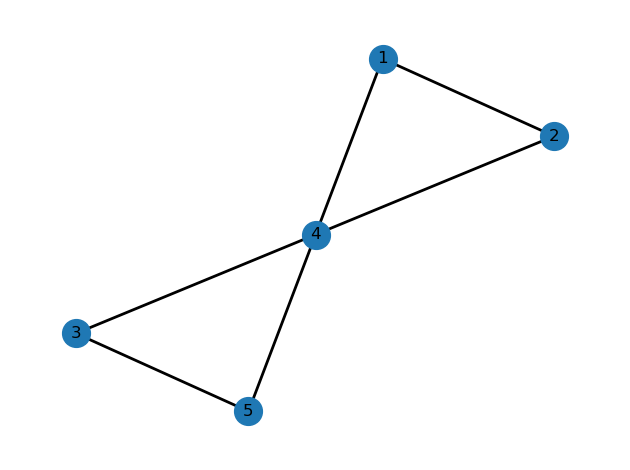

100%|██████████| 1000/1000 [00:01<00:00, 650.15it/s]

The average training error: 1.377
The average validation error: 1.407
The average test error: 1.354
Node-i: (train_errors[i], val_errors[i], test_errors[i])
Node-1: (1.136, 1.142, 1.061)
Node-2: (1.123, 1.214, 1.097)
Node-3: (1.603, 1.585, 1.685)
Node-4: (1.52, 1.577, 1.361)
Node-5: (1.503, 1.514, 1.565)


In [11]:
tune_FedSGD = True
iter = 1000
batch = 512
gtvmin_alphas = [1, 0.5, 0.1]
learning_rates = [0.1, 0.01, 0.001]
nums_neighnors = [1, 2, 3, 4]

if not tune_FedSGD:
    best_num_neigbors = 2
    best_gtvmin_alpha = 0.1
    best_learning_rate = 0.1
else:
    min_val_loss = np.inf
    best_gtvmin_alpha = None
    best_learning_rate = None
    best_num_neigbors = None
    for num_neighbors in nums_neighnors:
        for gtvmin_alpha in gtvmin_alphas:
            for learning_rate in learning_rates:
                G = get_emprical_graph(df)
                G = add_edges_rep_vector(G, num_neighbors)
                
                if not nx.is_connected(G):
                    continue
                print(f"Validation of (gtvmin_alpha, learning_rate, num_neighbors) = {(gtvmin_alpha, learning_rate, num_neighbors)}")
                FedSGD(G, gtvmin_alpha, learning_rate, batch, iter)
                _, val_loss, _ = get_losses(G, print_losses=False)
                val_loss = np.mean(val_loss)
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    best_gtvmin_alpha = gtvmin_alpha
                    best_learning_rate = learning_rate
                    best_num_neigbors = num_neighbors
                    print("The best values are updated")


G = get_emprical_graph(df)
G = add_edges_rep_vector(G, best_num_neigbors)
plot_G(G)
FedSGD(G, best_gtvmin_alpha, best_learning_rate, batch, iter)
train_errors, val_errors, test_errors = get_losses(G)

print_losses(train_errors, val_errors, test_errors)

## FedAVG

In [12]:
def FedAVGv1(G : nx.Graph, learning_rate : float = 0.001, max_iter : int = 100):
    """
    Applies federated averaging

    Inputs:
    G (nx.Graph): Empirical graph
    learning_rate (float): Learning rate
    max_iter (int): Maximum number of iterations
    """
    w_shape = G.nodes[0]["weights"].shape
    global_w = np.zeros(w_shape)
    
    for _ in tqdm(range(max_iter)):
        w_sum = np.zeros(w_shape)
        for node in G.nodes:
            train_size = G.nodes[node]["train_size"]
            X_train = G.nodes[node]["X_train"]
            y_train = G.nodes[node]["y_train"][:, None]
            G.nodes[node]["weights"] = global_w + learning_rate * (2 / train_size) * X_train.T.dot(y_train - X_train.dot(global_w))
            w_sum += G.nodes[node]["weights"]
        
        global_w = w_sum / len(G.nodes)

def FedAVGv2(G : nx.Graph, learning_rate : float = 0.001, max_iter : int = 100):
    """
    Applies federated averaging

    Inputs:
    G (nx.Graph): Empirical graph
    learning_rate (float): Learning rate
    max_iter (int): Maximum number of iterations
    """
    w_shape = G.nodes[0]["weights"].shape
    global_w = np.zeros(w_shape)
    
    for _ in tqdm(range(max_iter)):
        w_sum = np.zeros(w_shape)
        for node in G.nodes:
            train_size = G.nodes[node]["train_size"]
            X_train = G.nodes[node]["X_train"]
            y_train = G.nodes[node]["y_train"][:, None]
            A = X_train.T.dot(X_train) + (train_size / learning_rate) * np.eye(w_shape[0])
            b = X_train.T.dot(y_train) + (train_size / learning_rate) * global_w
            G.nodes[node]["weights"] = np.linalg.solve(A, b)
            w_sum += G.nodes[node]["weights"]
        
        global_w = w_sum / len(G.nodes)

Validation of (learning_rate) = 0.1


100%|██████████| 1000/1000 [00:01<00:00, 872.69it/s]


The best values are updated
Validation of (learning_rate) = 0.01


100%|██████████| 1000/1000 [00:01<00:00, 931.56it/s]


Validation of (learning_rate) = 0.001


100%|██████████| 1000/1000 [00:00<00:00, 1009.12it/s]


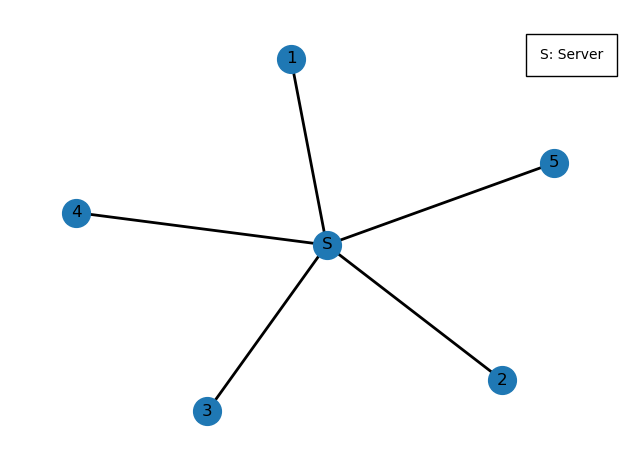

100%|██████████| 1000/1000 [00:01<00:00, 958.53it/s]

The average training error: 1.816
The average validation error: 1.834
The average test error: 1.798
Node-i: (train_errors[i], val_errors[i], test_errors[i])
Node-1: (1.728, 1.749, 1.666)
Node-2: (1.724, 1.81, 1.706)
Node-3: (2.104, 2.085, 2.224)
Node-4: (1.704, 1.764, 1.525)
Node-5: (1.819, 1.763, 1.87)


In [13]:
tune_FedAVGv1 = True
iter = 1000
learning_rates = [0.1, 0.01, 0.001]

if not tune_FedAVGv1:
    best_learning_rate = 0.1
else:
    min_val_loss = np.inf
    best_learning_rate = None
    for learning_rate in learning_rates:
        G = get_emprical_graph(df)
        print(f"Validation of (learning_rate) = {(learning_rate)}")
        FedAVGv1(G, learning_rate = learning_rate, max_iter=iter)
        _, val_loss, _ = get_losses(G, print_losses=False)
        val_loss = np.mean(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_learning_rate = learning_rate
            print("The best values are updated")

G = get_emprical_graph(df)
plot_G(G)
FedAVGv1(G, learning_rate = best_learning_rate, max_iter=iter)
train_errors, val_errors, test_errors = get_losses(G)

print_losses(train_errors, val_errors, test_errors)

Validation of (learning_rate) = 0.1


100%|██████████| 1000/1000 [00:03<00:00, 288.60it/s]


The best values are updated
Validation of (learning_rate) = 0.01


100%|██████████| 1000/1000 [00:03<00:00, 281.93it/s]


Validation of (learning_rate) = 0.001


100%|██████████| 1000/1000 [00:03<00:00, 287.52it/s]


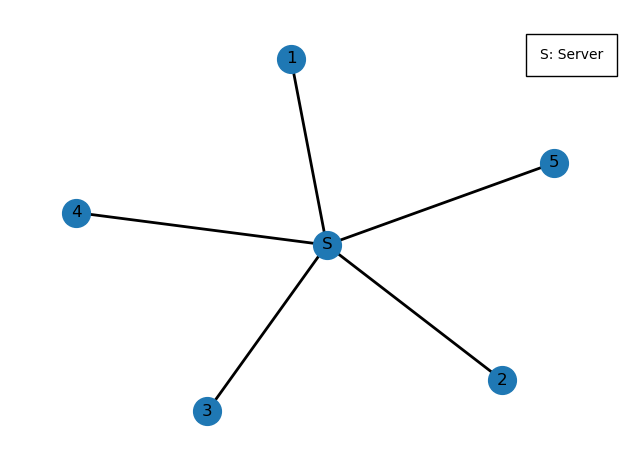

100%|██████████| 1000/1000 [00:03<00:00, 290.71it/s]

The average training error: 1.911
The average validation error: 1.928
The average test error: 1.897
Node-i: (train_errors[i], val_errors[i], test_errors[i])
Node-1: (1.828, 1.843, 1.767)
Node-2: (1.829, 1.913, 1.81)
Node-3: (2.236, 2.216, 2.358)
Node-4: (1.767, 1.839, 1.592)
Node-5: (1.895, 1.827, 1.957)


In [14]:
tune_FedAVGv2 = True
iter = 1000
learning_rates = [0.1, 0.01, 0.001]

if not tune_FedAVGv2:
    best_learning_rate = 0.1
else:
    min_val_loss = np.inf
    best_learning_rate = None
    for learning_rate in learning_rates:
        G = get_emprical_graph(df)
        print(f"Validation of (learning_rate) = {(learning_rate)}")
        FedAVGv2(G, learning_rate = learning_rate, max_iter=iter)
        _, val_loss, _ = get_losses(G, print_losses=False)
        val_loss = np.mean(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_learning_rate = learning_rate
            print("The best values are updated")

G = get_emprical_graph(df)
plot_G(G)
FedAVGv2(G, learning_rate = best_learning_rate, max_iter=iter)
train_errors, val_errors, test_errors = get_losses(G)

print_losses(train_errors, val_errors, test_errors)